# Video Synopsis on synthetic data

*Authors: Lemuel Puglisi & Luigi Seminara*

Apply the He Et al. algorithm to videos generated by the program TrafficSimulator. 

In [1]:
import pandas as pd

trackingdf = pd.read_csv('./data-simulation/tracking_20220523_210923.csv', skiprows=2)
trackingdf.head()

,frameId,objectId,x,y,z,tl_x,tl_y,br_x,br_y
0,136,1777,-20,0,-1,1822,414,2080,504
1,137,1777,-20,0,-1,1822,414,2080,504
2,138,1777,-19,0,-1,1792,414,2048,504
3,139,1777,-19,0,-1,1792,414,2048,504
4,140,1777,-18,0,-1,1761,414,2015,504


Convert the CSV format from the simulator to our tubes format:

In [2]:
tubes_path = './synopsis/simulation.txt'

inserted = set()

with open('./synopsis/simulation.txt', 'w+') as output:
    for idx, (fr, obj, _, _, _, tlx, tly, brx, bry) in trackingdf.iterrows():
        if int(tlx) < 0 or int(tly) < 0: continue
        w = int(brx) - int(tlx)
        h = int(bry) - int(tly)
        line = f"{fr//2} {obj} {tlx} {tly} {w} {h} -1 -1 -1 0 \n"
        if line in inserted: continue
        inserted.add(line)
        output.write(line)

Import the libraries and set the parameters.

> Note: we don't need to set -c (confidence) as the tracking part is no longer needed here. 

In [9]:
from pcgvs.extraction import extract_tubes, extract_patches, extract_background, load_tubes_from_pandas_dataframe, load_tubes_with_pandas
from pcgvs.aggregation import solve, add_ss_to_dataframe
from pcgvs.aggregation.relations import RelationsMap
from pcgvs.aggregation.graph import PCG
from pcgvs.aggregation.coloring import color_graph, tubes_starting_time
from pcgvs.synopsis import generate_frames, generate_synopsis

i = '/Users/nguyenduy/Desktop/pcgvs-main/notebooks/videos/video4.mp4'
o = './synopsis/'
q = 8
t = 4
interp = True

Extract the patches of every object in every frame, and then perform the background extraction. 

In [10]:
# Extraction
tubes_path='/Users/nguyenduy/Desktop/pcgvs-main/notebooks/data/trungquoc.txt'
patches_path = extract_patches(source=i, outputdir=o, path_tubes=tubes_path)
background_path = extract_background(source=i, outputdir=o, path_tubes=tubes_path)

4515it [00:06, 648.38it/s]                           

extracting background | frame 2
extracting background | frame 3
extracting background | frame 4
extracting background | frame 5
extracting background | frame 6
extracting background | frame 7
extracting background | frame 8
extracting background | frame 9
extracting background | frame 10
extracting background | frame 11
extracting background | frame 12
extracting background | frame 13


Aggregate the tubes using the potential collision graph coloring algorithm. 

In [11]:
# Aggregation
dataframe = load_tubes_with_pandas(tubes_path)
tubes = load_tubes_from_pandas_dataframe(dataframe)

print('computing the relations')
relations = RelationsMap(tubes)
# print(relations)

print('Generating the potential collision graph')
pcg = PCG(tubes, relations)

print('Applying graph coloring algorithm')
color_graph(pcg, q)

starting_times = tubes_starting_time(pcg, q)

computing the relations


100%|██████████| 552/552 [00:23<00:00, 23.33it/s] 


Generating the potential collision graph
Applying graph coloring algorithm


100%|██████████| 944/944 [00:05<00:00, 163.89it/s] 


From the condensed starting times, generate the video synopsis.  

In [12]:
# Synopsis
df = add_ss_to_dataframe(dataframe, tubes, starting_times)
frames = generate_frames(df, patches_path)

# generate_synopsis(frames, o, 30, background_path, interp)
# print('Video synopsis generated')

See the result:

![simulation](./data-simulation/synopsis.gif)

# Metrics evaluation

Utility functions:

In [13]:
import cv2
import numpy as np

def _get_video_duration(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count/fps
    cap.release()
    return duration


def _get_video_resolution(video_path):
    cap = cv2.VideoCapture(video_path)
    w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    cap.release()
    return int(w), int(h)

In [14]:
vpath = '/Users/nguyenduy/Desktop/pcgvs-main/notebooks/videos/video4.mp4'
spath = './synopsis/synopsis.avi'

Frame condensation ratio (FR):

In [15]:
import cv2

def FR(synopsis_video_path: str, original_video_path: str):
    """ Frame condensation ratio """
    Ts = _get_video_duration(synopsis_video_path)
    Ti = _get_video_duration(original_video_path)
    return Ts / Ti

print(f'FR is {FR(spath, vpath):.3f}')

FR is 0.041


Frame compact rate (CR):

> Note: the metric includes even the area out of the road, where there aren't cars. 

In [16]:
def CR(synopsis_video_path: str, frames: dict):
    """ Frame compact rate """
    w, h = _get_video_resolution(synopsis_video_path)
    multiplier = 1 / (w * h * len(frames))
    foreg_area = 0
    for objects in frames.values():
        for obj in objects:
            x, y, _w, _h = obj['x'], obj['y'], obj['w'], obj['h']
            foreg_area += min(_w, w - x) * min(_h, h - y)
    _CR = multiplier * foreg_area
    return _CR

print(f'CR is {CR(spath, frames):.3f}')

CR is 0.330


Overlap ratio (OR):

In [17]:
def OR(synopsis_video_path: str, frames: dict):
    """ Overlap ratio """
    w, h = _get_video_resolution(synopsis_video_path)
    multiplier = 1 / (w * h * len(frames))
    overlap_area = 0
    for objects in frames.values():
        F = np.zeros((w, h))
        for obj in objects:
            x, y, _w, _h = obj['x'], obj['y'], obj['w'], obj['h'] 
            F[x:(x+_w), y:(y+_h)] += np.ones((min(_w, w - x), min(_h, h - y)))
        overlap_area += (F > 1).sum()
    _OR = multiplier * overlap_area
    return _OR

print(f'OR is {OR(spath, frames):.3f}')

OR is 0.069


##  q-related metrics evaluation

Summarize the pipeline in a function in order to evaluate the metrics versus different values of q.

In [1]:
from pcgvs.extraction import extract_tubes, extract_patches, extract_background, load_tubes_from_pandas_dataframe, load_tubes_with_pandas
from pcgvs.aggregation import solve, add_ss_to_dataframe
from pcgvs.aggregation.relations import RelationsMap
from pcgvs.aggregation.graph import PCG
from pcgvs.aggregation.coloring import color_graph, tubes_starting_time
from pcgvs.synopsis import generate_frames, generate_synopsis
from pcgvs.metrics import FR, CR, OR


def pipeline(q: int):
    i = './data-simulation/export_20220523_210923.mp4'
    tubes_path = './synopsis/simulation.txt'
    o = './synopsis/'
    interp = True
    t = 4
    
    # Extraction
    patches_path = extract_patches(source=i, outputdir=o, path_tubes=tubes_path)
    background_path = extract_background(source=i, outputdir=o, path_tubes=tubes_path)
    
    # Aggregation
    dataframe = load_tubes_with_pandas(tubes_path)
    tubes = load_tubes_from_pandas_dataframe(dataframe)
    print('computing the relations')
    relations = RelationsMap(tubes)
    print('Generating the potential collision graph')
    pcg = PCG(tubes, relations)
    print('Applying graph coloring algorithm')
    color_graph(pcg, q)
    starting_times = tubes_starting_time(pcg, q)
    
    # Synopsis
    df = add_ss_to_dataframe(dataframe, tubes, starting_times)
    frames = generate_frames(df, patches_path)
    generate_synopsis(frames, o, 30, background_path, interp)
    print(f'Video synopsis generated with q={q}')
    
    spath = './synopsis/synopsis.avi'
    vpath = './data-simulation/export_20220523_210923.mp4'
    
    # metrics
    _FR = FR(spath, vpath)
    _CR = CR(spath, frames)
    _OR = OR(spath, frames)
    
    return _FR, _CR, _OR

Save the results in a json file.

In [ ]:
import json

metrics_by_q = {}

for q in [0, 3, 5, 8, 10, 15]:
    print(f'processing pipeline using q={q}')
    metrics_by_q[q] = pipeline(q)

metrics_save = { str(k):v for k, v in metrics_by_q.items() }

with open('./data-simulation/metrics.json', 'w') as metricsfile:
    json.dump(metrics_save, metricsfile)

In [58]:
import json 

with open('./data-simulation/metrics.json', 'r') as metricsfile:
    metrics_by_q = json.load(metricsfile)

Plot the results. As the authors of the paper points out, the metrics seems to be proportional to the parameter `q`. This implies that the choice of q is a trade-off between the CR and OR metrics. 

*Note: why when $q=1$ $CR>1$? Because we also added bounding box areas outside of the frame. This is bug is now fixed.*

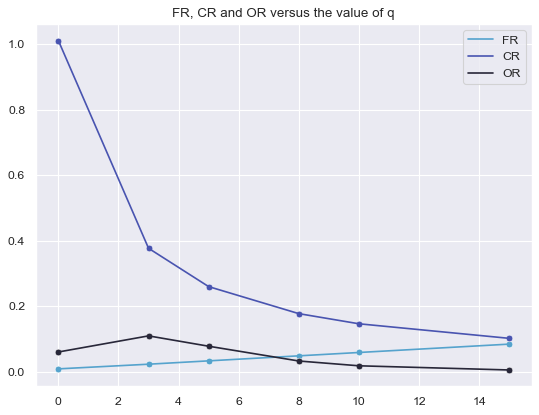

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_palette("icefire")

Q = [0, 3, 5, 8, 10, 15]

plt.figure(figsize=(8, 6), dpi=80)

qFR = [ metrics_by_q[str(q)][0] for q in Q ]
qCR = [ metrics_by_q[str(q)][1] for q in Q ]
qOR = [ metrics_by_q[str(q)][2] for q in Q ]

sns.lineplot(x=Q, y=qFR, palette=sns.color_palette()[1])
sns.lineplot(x=Q, y=qCR, palette=sns.color_palette()[3])
sns.lineplot(x=Q, y=qOR, palette=sns.color_palette()[5])

sns.scatterplot(x=Q, y=qFR, palette=sns.color_palette()[1])
sns.scatterplot(x=Q, y=qCR, palette=sns.color_palette()[3])
sns.scatterplot(x=Q, y=qOR, palette=sns.color_palette()[5])

plt.title('FR, CR and OR versus the value of q')
plt.legend(labels=["FR","CR", "OR"])
plt.show()


# Conclusions

Metrics from our implementation applied to the Traffic Simulator dataset are comparable to the results obtained in the paper He Et al. This suggests that researchers can use handly data generated from a simulator to test the performances of their algorithms, instead of hoping to get access to a large video synopsis dataset, or spend time generating it. 